In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import timm
import random
import math
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(5148)

In [3]:
dataset_path = './Rice_Image_Dataset'
classes = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        classes.append(folder)


In [4]:
img_sample = []
for cat in classes:
    folder_path = os.path.join(dataset_path, cat)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        img_sample.append(img)
        break

In [5]:
all_images = []
all_labels = []

for label in classes:
    folder = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        all_images.append(img_path)
        all_labels.append(label)

In [6]:
# Split data into training and temporary (val+test) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42
)

# Split the temporary set into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        self.label_to_int = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB in case some images are grayscale

        if self.transform:
            image = self.transform(image)
        
        # Convert the label from string to integer
        label = self.label_to_int[label]

        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_images, val_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
def validate(model):
    preds = []
    labels = []
    for x, y in tqdm(val_loader):
        x = x.to(device)
        y = y.to(device)
        preds.append(model(x).argmax(dim=1))
        labels.append(y)
    return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

def test(model):
    preds = []
    labels = []
    for x, y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)
        preds.append(model(x).argmax(dim=1))
        labels.append(y)
    return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

In [10]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, feature_dim, num_classes, normalize=False, initial_weights=None):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.classification_head = torch.nn.Linear(feature_dim, num_classes)
        self.normalize = normalize
        if not self.normalize:
            print('normalize skipped.')

        if initial_weights is not None and type(initial_weights) == tuple:
            print('tuple.')
            w, b = initial_weights
            self.classification_head.weight = torch.nn.Parameter(w.clone())
            self.classification_head.bias = torch.nn.Parameter(b.clone())
        else:
            if initial_weights is None:
                initial_weights = torch.zeros_like(self.classification_head.weight)
                torch.nn.init.kaiming_uniform_(initial_weights, a=math.sqrt(5))
            self.classification_head.weight = torch.nn.Parameter(initial_weights.clone())
            # Note: modified. Initial bug in forgetting to zero bias.
            self.classification_head.bias = torch.nn.Parameter(torch.zeros_like(self.classification_head.bias))

        # Note: modified. Get rid of the language part.
        if hasattr(self.model, 'transformer'):
            delattr(self.model, 'transformer')


    def forward(self, images):
        features = self.model.encode_image(images).float()
        if self.normalize:
            features = features / features.norm(dim=-1, keepdim=True)
        logits = self.classification_head(features)
        return logits

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dicts = []
# 0.0005, 0.0003, aug0.0003, 0.0001
file_name=['pre_DenseNet_seed.pt','pre_DenseNet_seed_2.pt','best_model.pt','pre_DenseNet_seed_1.pt']
for f in file_name:
    print(f'Loading {f}')
    state_dicts.append(torch.load(f,map_location=device))

Loading pre_DenseNet_seed.pt
Loading pre_DenseNet_seed_2.pt
Loading best_model.pt
Loading pre_DenseNet_seed_1.pt


In [12]:
val_results = []
test_results = []

def define_model(file_name):
    class DenseNet(nn.Module):
        def __init__(self, num_classes=5):  # Assuming 5 classes for classification
            super(DenseNet, self).__init__()
            self.densenet= timm.create_model('densenet121', pretrained=True, num_classes=num_classes)
        def forward(self, x):
            return self.densenet(x)
    # 모델 불러오기
    densenet_model = DenseNet().to(device)
    densenet_model.load_state_dict(torch.load(file_name))
    return densenet_model

for i in range(len(state_dicts)):
    #feature_dim = model.head.fc.weight.shape[1]
    feature_dim=1024
    num_classes = 5
    normalize = True
    model=define_model(file_name[i])
    val_results.append(validate(model))
    test_results.append(test(model))


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [13]:
def get_model(state_dicts, alphal):
    feature_dim=1024
    num_classes = 5
    model=define_model(file_name[0])
    sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
    for i in range(1, len(state_dicts)):
        for k in state_dicts[i].keys():
            sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
    model.load_state_dict(sd)
    model = model.to(device)
    return model

([0, 1, 2, 3],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4')])

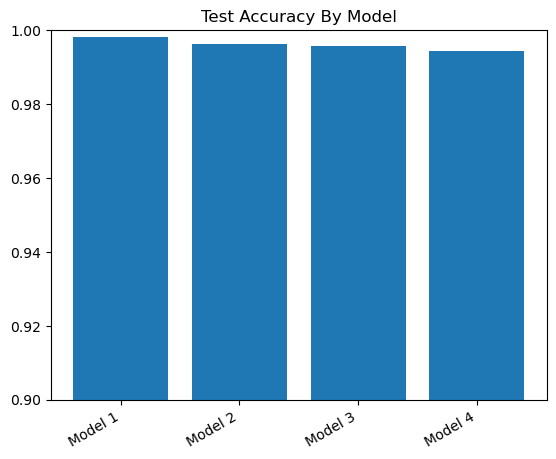

In [14]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.90,1])
plt.xticks(rotation=30, ha='right')

In [15]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_results.append(test(model))

  0%|          | 0/938 [00:00<?, ?it/s]

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Uniform Soup')])

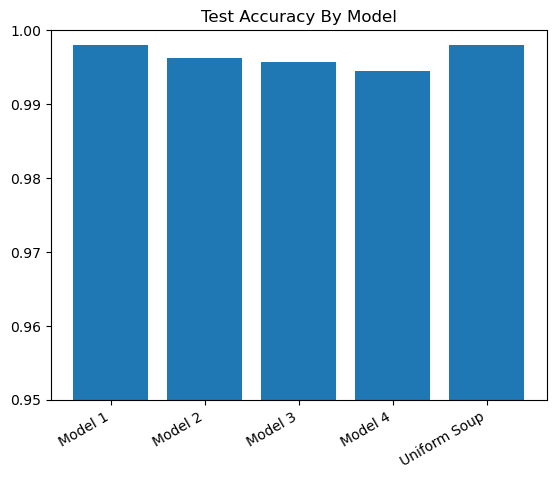

In [16]:
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

In [17]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
    # add current index to the ingredients
    ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
    alphal = [0 for i in range(len(state_dicts))]
    for j in ingredient_indices:
        alphal[j] = 1 / len(ingredient_indices)
  
    # benchmark and conditionally append
    model = get_model(state_dicts, alphal)
    current = validate(model)
    print(f'Models {ingredient_indices} got {current*100}% on validation.')
    if current > current_best:
        current_best = current
        best_ingredients = ingredient_indices



  0%|          | 0/938 [00:00<?, ?it/s]

Models [0, 1] got 99.76000189781189% on validation.


  0%|          | 0/938 [00:00<?, ?it/s]

Models [0, 2] got 99.05333518981934% on validation.


  0%|          | 0/938 [00:00<?, ?it/s]

Models [0, 3] got 99.80000257492065% on validation.


In [18]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
    alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)

test_results.append(test(model))

  0%|          | 0/938 [00:00<?, ?it/s]

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Uniform Soup'),
  Text(5, 0, 'Greedy Soup')])

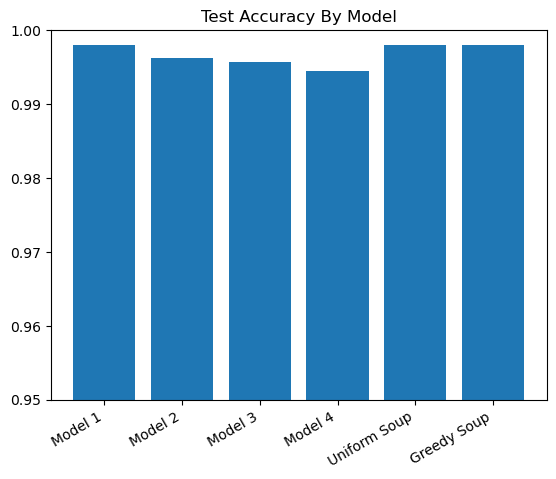

In [19]:
names.append("Greedy Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

In [21]:
for i in range(len(names)):
    print(names[i],"Accuracy:",test_results[i])

Model 1 Accuracy: 0.9980666637420654
Model 2 Accuracy: 0.9962000250816345
Model 3 Accuracy: 0.9956666827201843
Model 4 Accuracy: 0.9944666624069214
Uniform Soup Accuracy: 0.9980000257492065
Greedy Soup Accuracy: 0.9980666637420654
